# Imports

In [1]:
import os
from pathlib import Path
from functools import partial
from typing import List, Optional, Union
import json

from tqdm import tqdm
import einops
import math
import numpy as np
import plotly.express as px
import plotly.io as pio
import plotly.graph_objects as go
from neel_plotly import line, imshow, scatter # pip install git+https://github.com/neelnanda-io/neel-plotly.git
import torch
from torch import Tensor
from circuitsvis.attention import attention_heads
from fancy_einsum import einsum
from IPython.display import HTML, IFrame
from jaxtyping import Float
from typing import List, Optional, Tuple, Dict, Literal, Set
from rich.table import Table, Column
from rich import print as rprint
import matplotlib.pyplot as plt
import seaborn as sns


import transformer_lens.utils as utils
from transformer_lens import ActivationCache, HookedTransformer

torch.set_grad_enabled(False)
print("Disabled automatic differentiation")

update_layout_set = {"xaxis_range", "yaxis_range", "yaxis2_range", "hovermode", "xaxis_title", "yaxis_title", "colorbar", "colorscale", "coloraxis", "title_x", "bargap", "bargroupgap", "xaxis_tickformat", "yaxis_tickformat", "title_y", "legend_title_text", "xaxis_showgrid", "xaxis_gridwidth", "xaxis_gridcolor", "yaxis_showgrid", "yaxis_gridwidth", "yaxis_gridcolor", "showlegend", "xaxis_tickmode", "yaxis_tickmode", "margin", "xaxis_visible", "yaxis_visible", "bargap", "bargroupgap", "xaxis_tickangle"}
from transformer_lens.utils import to_numpy

def bar(tensor, renderer=None, **kwargs):
    '''
    '''
    kwargs_post = {k: v for k, v in kwargs.items() if k in update_layout_set}
    kwargs_pre = {k: v for k, v in kwargs.items() if k not in update_layout_set}
    if "margin" in kwargs_post and isinstance(kwargs_post["margin"], int):
        kwargs_post["margin"] = dict.fromkeys(list("tblr"), kwargs_post["margin"])
    px.bar(y=to_numpy(tensor), **kwargs_pre).update_layout(**kwargs_post).show(renderer)

def line(tensor, **kwargs):
    px.line(
        y=utils.to_numpy(tensor),
        **kwargs,
    ).show()


def scatter(x, y, xaxis="", yaxis="", caxis="", **kwargs):
    x = utils.to_numpy(x)
    y = utils.to_numpy(y)
    px.scatter(
        y=y,
        x=x,
        labels={"x": xaxis, "y": yaxis, "color": caxis},
        **kwargs,
    ).show()

# Automatically reload scripts that are modified outside of the notebook
%load_ext autoreload
%autoreload 2

Disabled automatic differentiation


# Model Loading

The various flags are simplifications that preserve the model's output but simplify its internals:

In [2]:
model = HookedTransformer.from_pretrained(
    "meta-llama/Llama-3.2-1B",   
    center_unembed=True,
    center_writing_weights=True,
    fold_ln=True,
    refactor_factored_attn_matrices=False,
)                              

device: torch.device = utils.get_device()

Loaded pretrained model meta-llama/Llama-3.2-1B into HookedTransformer


# Import Dataset and Setup 

In [3]:
from data.homonymy_dataset import Dataset

dataset = Dataset(file_path="data/homonymy_dataset.json", model=model, tokenizer=None, device=device)

all_prompts = dataset.all_prompts # pairs of clean and corr prompts
all_prompts_strings = dataset.all_prompts_strings # concatenated clean and corr prompts
all_answers = dataset.all_answer_strings # concatenated clean and corr answers
all_tokens = dataset.all_token_ids

all_answer_tok_ids = dataset.all_answer_tok_ids
clean_prompts = dataset.clean_prompts
clean_answers_tok_ids = dataset.clean_answer_tok_ids
corr_prompts = dataset.corr_prompts
corr_answers_tok_ids = dataset.corr_answer_tok_ids

/home/iustin/.conda/envs/tlens/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


# Forward pass

Forward pass to get logits and activation cache dictionary:

In [4]:
all_logits, all_cache = model.run_with_cache(all_tokens)

Iterate through the cached dictionary and print all saved activations and their shape:

In [5]:
for k, v in all_cache.items():
    print(k, v.shape)

hook_embed torch.Size([24, 18, 2048])
blocks.0.hook_resid_pre torch.Size([24, 18, 2048])
blocks.0.ln1.hook_scale torch.Size([24, 18, 1])
blocks.0.ln1.hook_normalized torch.Size([24, 18, 2048])
blocks.0.attn.hook_q torch.Size([24, 18, 32, 64])
blocks.0.attn.hook_k torch.Size([24, 18, 8, 64])
blocks.0.attn.hook_v torch.Size([24, 18, 8, 64])
blocks.0.attn.hook_rot_q torch.Size([24, 18, 32, 64])
blocks.0.attn.hook_rot_k torch.Size([24, 18, 8, 64])
blocks.0.attn.hook_attn_scores torch.Size([24, 32, 18, 18])
blocks.0.attn.hook_pattern torch.Size([24, 32, 18, 18])
blocks.0.attn.hook_z torch.Size([24, 18, 32, 64])
blocks.0.hook_attn_out torch.Size([24, 18, 2048])
blocks.0.hook_resid_mid torch.Size([24, 18, 2048])
blocks.0.ln2.hook_scale torch.Size([24, 18, 1])
blocks.0.ln2.hook_normalized torch.Size([24, 18, 2048])
blocks.0.mlp.hook_pre torch.Size([24, 18, 8192])
blocks.0.mlp.hook_pre_linear torch.Size([24, 18, 8192])
blocks.0.mlp.hook_post torch.Size([24, 18, 8192])
blocks.0.hook_mlp_out torc

Retrieve the `attn.hook_rot_q` and `attn.hook_rot_k` activations that serve as input to [GQA](https://arxiv.org/pdf/2305.13245) (Grouped Query Attention):

More information about how `hook_rot_q` and `hook_rot_k` are computed and their shapes in: 
1. `transformer_lens.components.abstract_attention` : functions for computing RoPE
2. `transformer_lens.components.grouped_query_attention`: apply RoPE in GQA Attention: 

    -  query_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos head_index d_model"]]`): The input tensor for the query projection.
    - key_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos kv_head_index d_model"]]`): The input tensor for the key projection. Note that is has as many **head dimensions as the GPA block has key-value heads**.
    - value_input (Union[Float[torch.Tensor, "batch pos d_model"], `Float[torch.Tensor, "batch pos kv_head_index d_model"]]`): The input tensor for the value projection. Note that is has as many **head dimensions as the GPA block has key-value heads**.

The `key-value heads` parameter is used to define the GQA group number, i.e. the subgroup of query heads that share a single key head and value head.

<details><summary>Technical implementation details of GQA</summary>

From `transformer_lens.components.grouped_query_attention` docstring:

Similar to regular attention, W_Q, W_K, and W_V all have shape `[head_index, d_model, d_head]`.
However, under the hood the key and value weights _W_K and _W_V are stored with shape `[n_key_value_heads, d_model, d_head]` and are expanded when the corresponding properties' getter is called.
Similarly, during a forward pass, initially K and V are kept in shapes `[batch, pos, n_key_value_heads, d_head]` and *will only be expanded to shapes* `[batch, pos, n_heads, d_head]` using `torch.repeat_interleave` **when the attention pattern (post-softmax) and z-scores (attention patterns weighted by value) are calculated**: 

attention scores QK dot-product: 

```
k = torch.repeat_interleave(k, dim=2, repeats=self.repeat_kv_heads)
return qk # pattern
```

z-scores (QKV): 
```
v = torch.repeat_interleave(v, dim=2, repeats=self.repeat_kv_heads)
return v * pattern 
```

Example for `torch.repeat_interleave`: 

```
x = torch.tensor([1, 2, 3])
x.repeat_interleave(2)
>>> tensor([1, 1, 2, 2, 3, 3])

y = torch.tensor([[1, 2], [3, 4]])
torch.repeat_interleave(y, 2)
>>> tensor([1, 1, 2, 2, 3, 3, 4, 4])

torch.repeat_interleave(y, 3, dim=1)
torch.repeat_interleave(y, torch.tensor([1, 2]), dim=0)
>>> tensor([[1, 1, 1, 2, 2, 2],
        [3, 3, 3, 4, 4, 4]])

torch.repeat_interleave(y, torch.tensor([1, 2]), dim=0, output_size=3)
>>> tensor([[1, 2],
        [3, 4],
        [3, 4]])

```

</details>

In [6]:
rot_act_q = utils.get_act_name('rot_q', '0', 'a')
rot_act_k = utils.get_act_name('rot_k', '0', 'a')

pre_rot_q = utils.get_act_name('q', '0', 'a')
pre_rot_k = utils.get_act_name('k', '0', 'a')

rot_act_q_cached = all_cache[rot_act_q]
rot_act_k_cached = all_cache[rot_act_k]

pre_rot_q_cached = all_cache[pre_rot_q]
pre_rot_k_cached = all_cache[pre_rot_k]

embed_cached = all_cache['hook_embed']

print("Shape of rot_act_q_cached:", rot_act_q_cached.shape) # (bsz, seq_len, n_heads, head_dim)
print("Shape of rot_act_k_cached:", rot_act_k_cached.shape) # (bsz, seq_len, kv_head_index, head_dim)

print("Shape of pre_rot_q_cached:", pre_rot_q_cached.shape) # (bsz, seq_len, n_heads, head_dim)
print("Shape of pre_rot_k_cached:", pre_rot_k_cached.shape) # (bsz, seq_len, kv_head_index, head_dim)
print("Shape of embed_cached:", embed_cached.shape)  # (bsz, seq_len, d_model)

Shape of rot_act_q_cached: torch.Size([24, 18, 32, 64])
Shape of rot_act_k_cached: torch.Size([24, 18, 8, 64])
Shape of pre_rot_q_cached: torch.Size([24, 18, 32, 64])
Shape of pre_rot_k_cached: torch.Size([24, 18, 8, 64])
Shape of embed_cached: torch.Size([24, 18, 2048])


In [7]:
assert model.cfg.n_key_value_heads == rot_act_k_cached.shape[2] == pre_rot_k_cached.shape[2], "Number of key-value heads should be equal to the number of attention heads"
assert model.cfg.d_model == embed_cached.shape[2], "Dimension of model should be equal to the dimension of the embeddings"

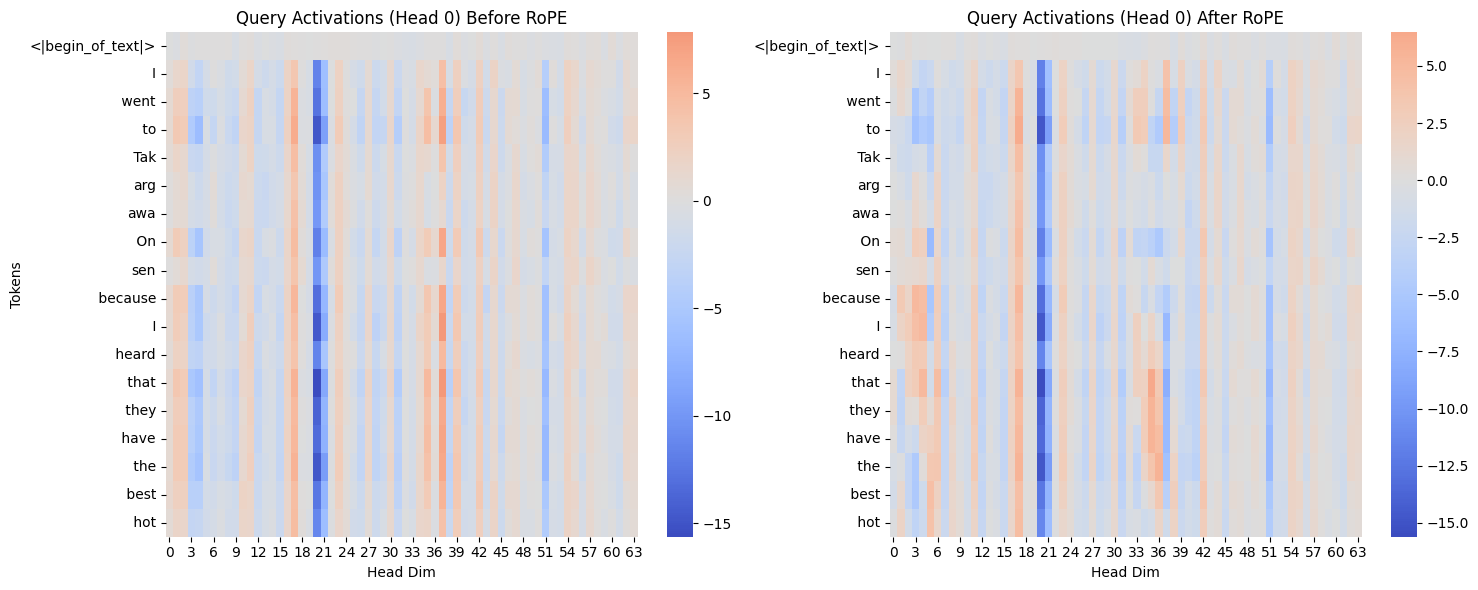

In [8]:
batch_idx = 1
head_idx = 0 # > 8 will error

# Extract post RoPE activations for a single batch and head
q_head_post = rot_act_q_cached[batch_idx, :, head_idx, :].cpu().numpy()  # Shape: (seq_len, head_dim)
q_head_pre = pre_rot_q_cached[batch_idx, :, head_idx, :].cpu().numpy() 

tokens = [model.tokenizer.decode([tok]) for tok in all_tokens[batch_idx]]

# Create a figure with two subplots (side-by-side heatmaps)
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Heatmap for pre-RoPE query activations
sns.heatmap(q_head_pre, cmap="coolwarm", center=0, ax=axes[0], yticklabels=tokens)
axes[0].set_title(f"Query Activations (Head {head_idx}) Before RoPE")
axes[0].set_xlabel("Head Dim")
axes[0].set_ylabel("Tokens")

# Heatmap for post-RoPE query activations
sns.heatmap(q_head_post, cmap="coolwarm", center=0, ax=axes[1], yticklabels=tokens)
axes[1].set_title(f"Query Activations (Head {head_idx}) After RoPE")
axes[1].set_xlabel("Head Dim")
axes[1].set_ylabel("")  # Remove redundant ylabel for cleaner visualization

# Show the plot
plt.tight_layout()
plt.show()

Prompt: <|begin_of_text|>Flowers bloom in the season of


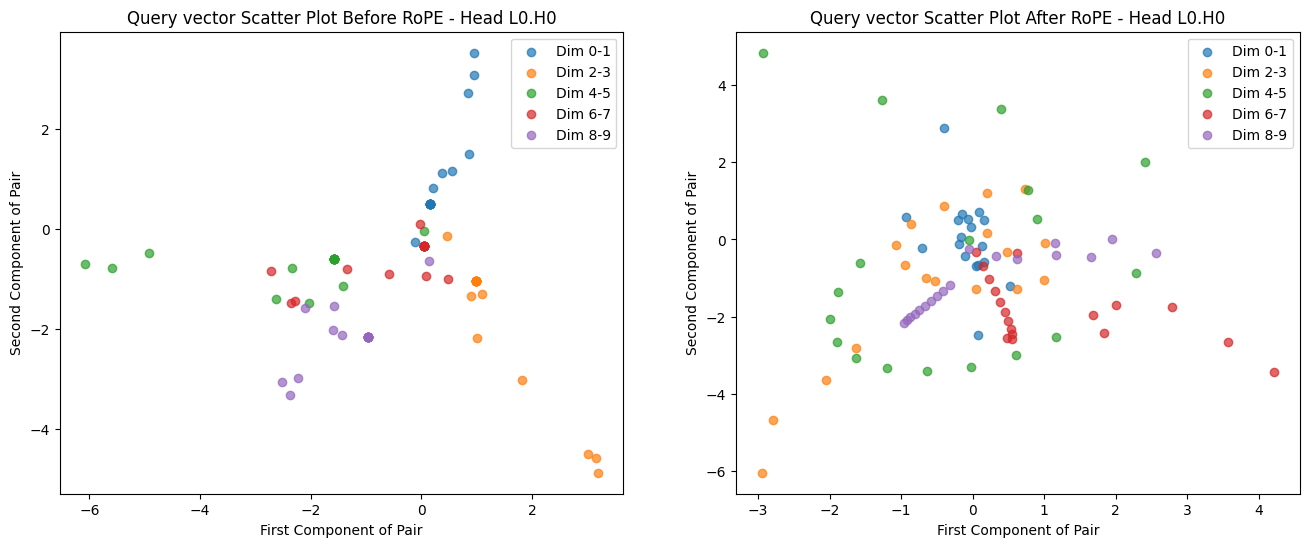

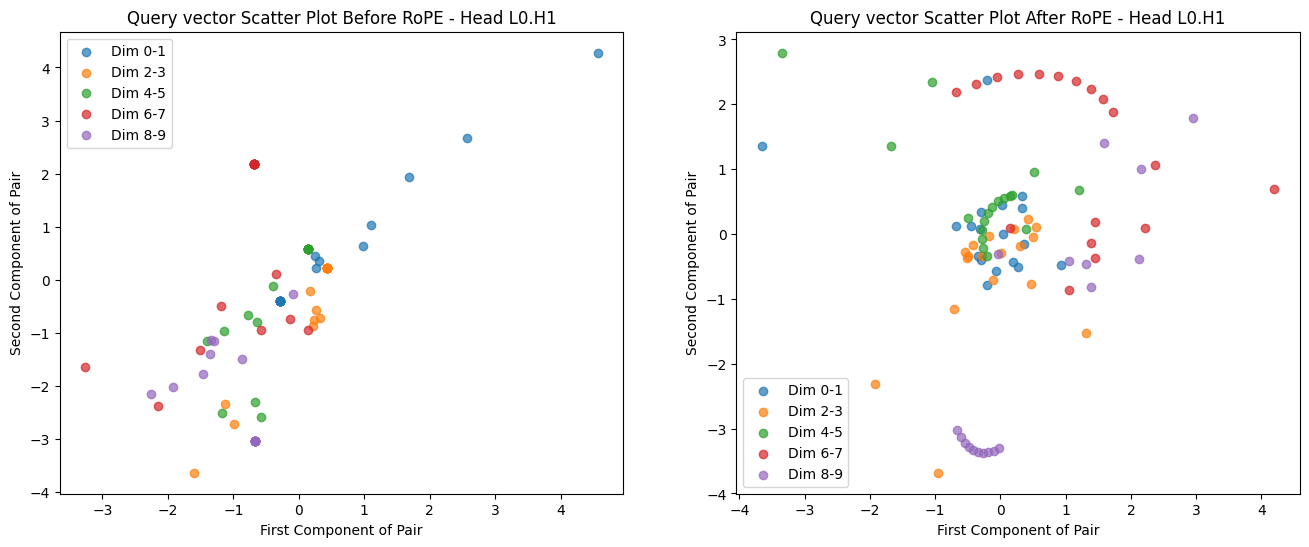

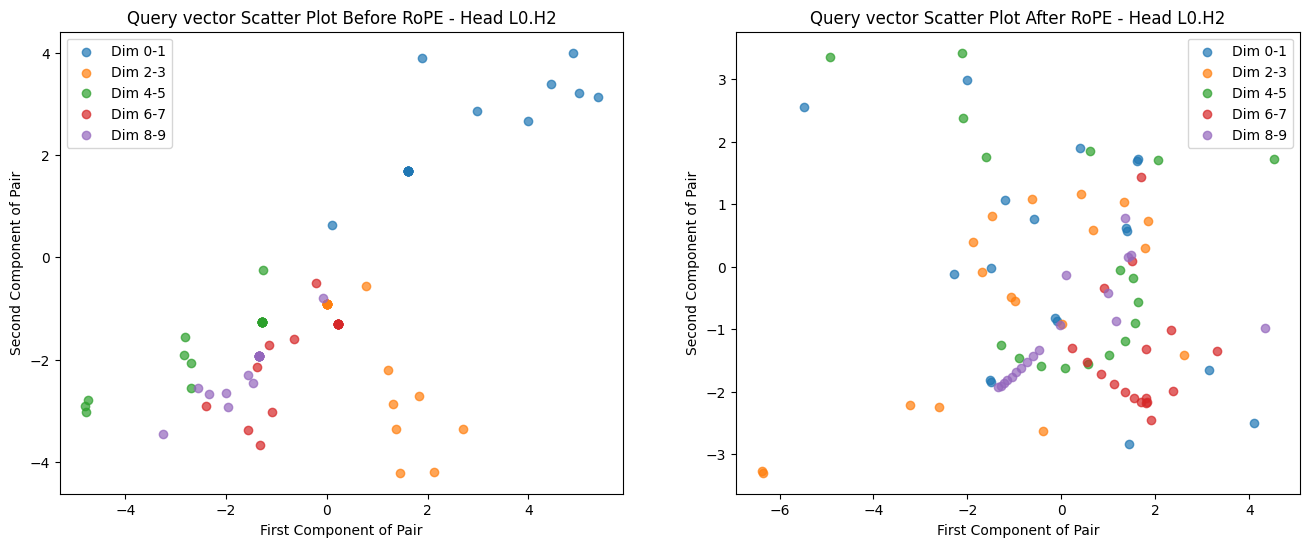

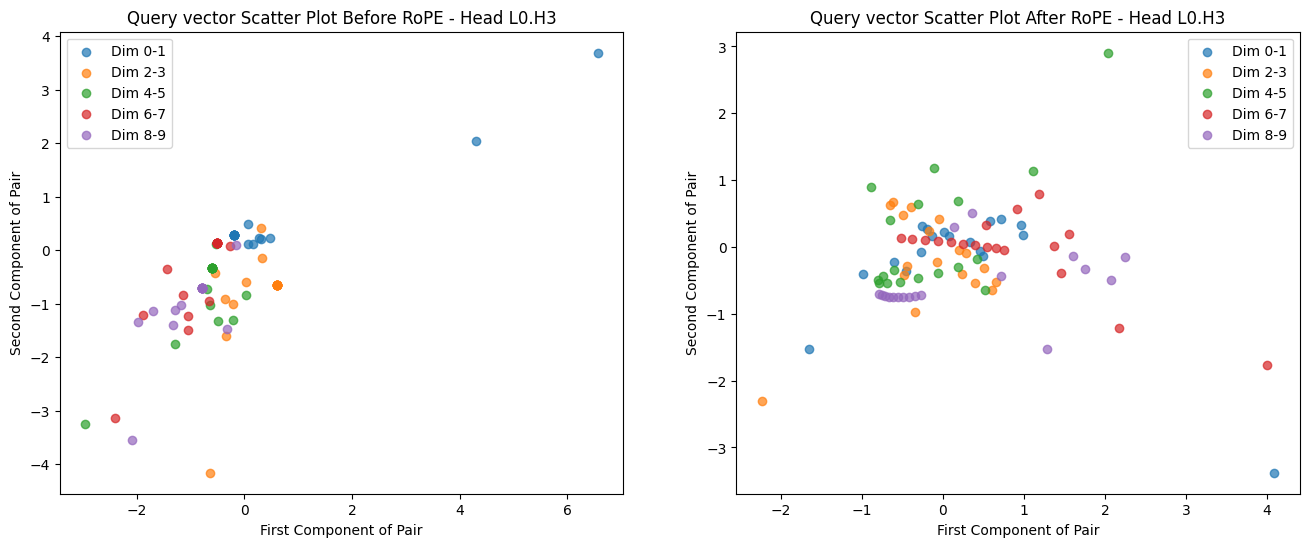

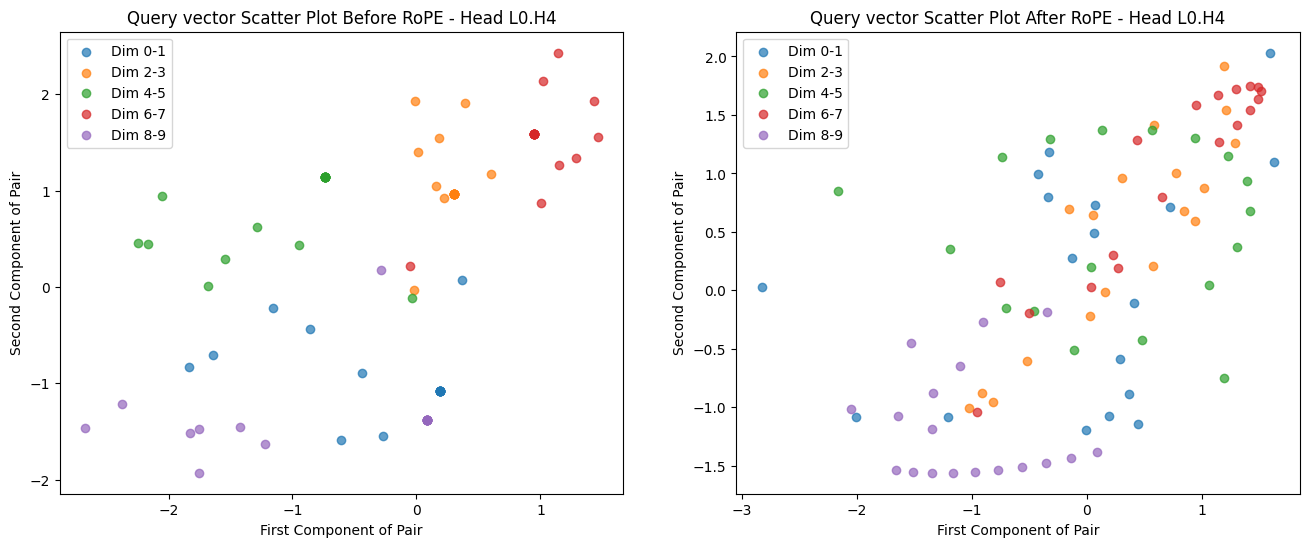

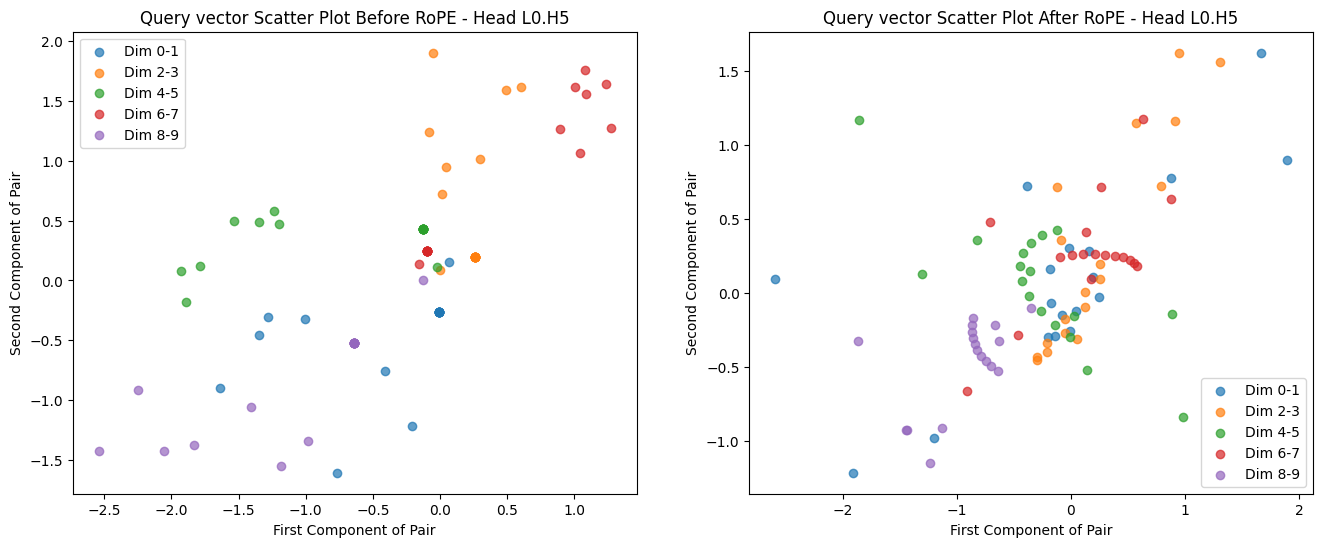

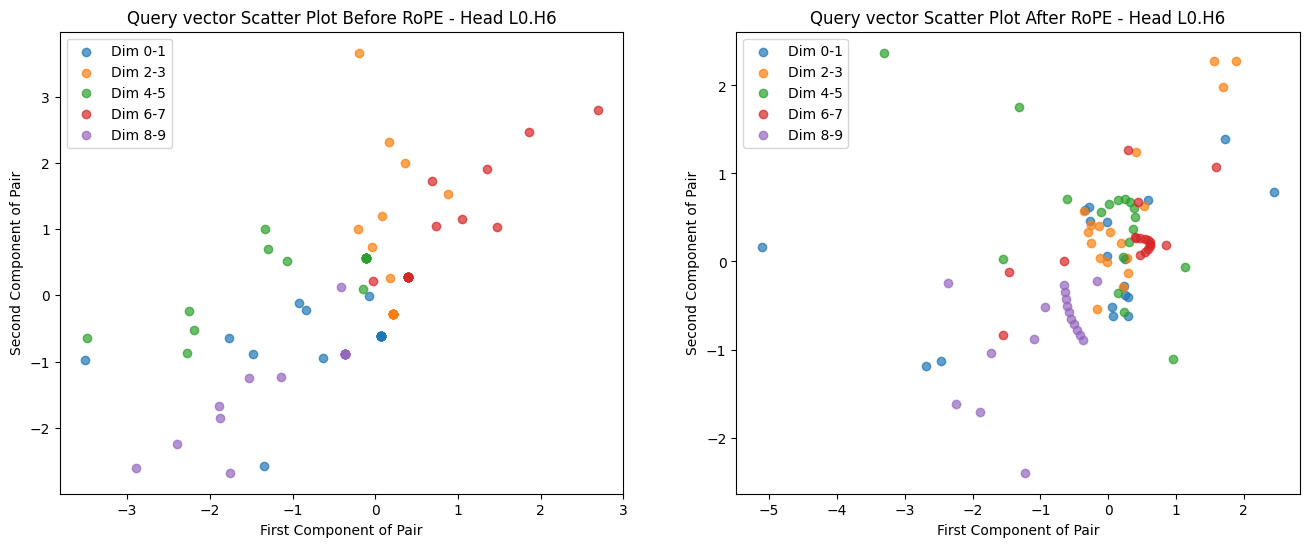

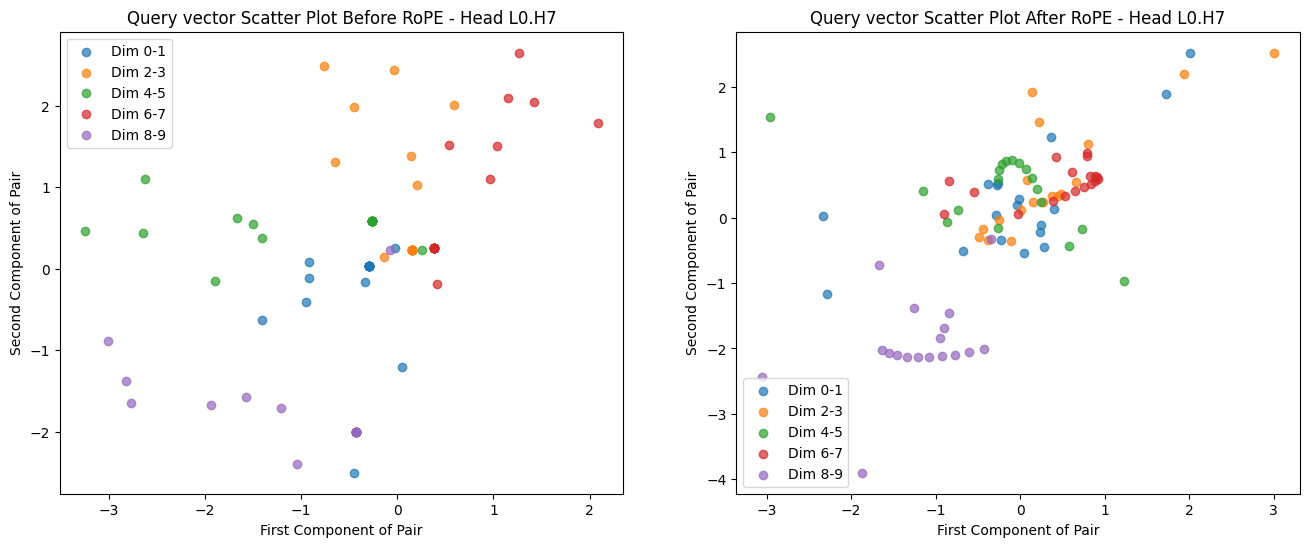

In [9]:
from src.patching.utils import strip_eot
# Choose a sequence index and attention head to visualize
seq_idx = 0
head_idx = 0

stripped_tokens = strip_eot(all_tokens[seq_idx], model.tokenizer.pad_token_id)
print(f'Prompt: {model.to_string(stripped_tokens)}')

for i in range(model.cfg.n_key_value_heads):
    # Extract activations for one head at the chosen sequence index (before and after RoPE)
    pre_q_head = pre_rot_q_cached[seq_idx, :, i, :].cpu().numpy()  # Pre-RoPE (Shape: seq_len, head_dim)
    post_q_head = rot_act_q_cached[seq_idx, :, i, :].cpu().numpy()  

    # Define 2D subspaces for visualization
    dim_pairs = list(range(0, q_head_post.shape[1], 2))  # Take pairs (0,1), (2,3), etc.

    # --- Side by Side Scatter Plot: Pre-RoPE and Post-RoPE Queries ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    # Pre-RoPE Queries
    for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
        axes[0].scatter(pre_q_head[:, dim], pre_q_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
    axes[0].set_title(f"Query vector Scatter Plot Before RoPE - Head L0.H{i}")
    axes[0].set_xlabel("First Component of Pair")
    axes[0].set_ylabel("Second Component of Pair")
    axes[0].legend()

    # Post-RoPE Queries
    for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
        axes[1].scatter(post_q_head[:, dim], post_q_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
    axes[1].set_title(f"Query vector Scatter Plot After RoPE - Head L0.H{i}")
    axes[1].set_xlabel("First Component of Pair")
    axes[1].set_ylabel("Second Component of Pair")
    axes[1].legend()

    plt.show()


In [10]:
pre_q_head = pre_rot_k_cached[batch_idx, :, head_idx, :]
post_q_head = rot_act_k_cached[batch_idx, :, head_idx, :]

pre_q_head_pairs = torch.stack([pre_q_head[:, dim], pre_q_head[:, dim + 1]], dim=-1)
post_q_head_pairs = torch.stack([post_q_head[:, dim], post_q_head[:, dim + 1]], dim=-1)

print(pre_q_head_pairs.shape)
print(post_q_head_pairs.shape)

torch.Size([18, 2])
torch.Size([18, 2])


In [27]:
dim_pairs_labels

['Dim 0-1', 'Dim 1-2']

In [30]:
model.cfg.d_head

64

In [35]:
from neel_plotly import line, imshow, scatter # pip install git+https://github.com/neelnanda-io/neel-plotly.git

dim_pairs_labels = [f"Dim {i}-{i+1}" for i in range(0, model.cfg.d_head, 2)]
print(f"pre_q_head_pairs shape: {pre_q_head_pairs.shape}")  # Expected (18, d_model or head_dim), but it might be (18, 2)
print(f"Shape of dim_pairs_labels: {dim_pairs_labels}")  # Expected (18,)
hover_labels = np.repeat(dim_pairs_labels, pre_q_head_pairs.shape[0])

# Ensure labels match number of scatter points
assert hover_labels.shape[0] == pre_q_head_pairs.flatten().shape[0], \
    f"Shape mismatch: {hover_labels.shape[0]} != {pre_q_head_pairs.flatten().shape[0]}"

print(f"pre_q_head_pairs shape: {pre_q_head_pairs.shape}")  # Should be (18, 2)
print(f"Flattened pre_q_head_pairs shape: {pre_q_head_pairs.flatten().shape}")  # Should be (36,)
print(f"Generated hover_labels shape: {hover_labels.shape}")  # Should also be (36,)

color = np.tile(np.arange(36 // 2), 2)  # Generates 18 unique colors, each repeated twice

scatter(
    x=utils.to_numpy(pre_q_head_pairs.flatten()),
    y=utils.to_numpy(post_q_head_pairs.flatten()),
    xaxis="Pre RoPE queries",
    yaxis="Post RoPE queries",
    # caxis="Layer",
    hover_name=hover_labels,  # Correct labels applied
    color=color,  # Ensures correct mapping
    range_x=(-0.5, 0.5),
    range_y=(-0.5, 0.5),
    title="Scatter plot of pre RoPE vs post RoPE queries",
)


pre_q_head_pairs shape: torch.Size([18, 2])
Shape of dim_pairs_labels: ['Dim 0-1', 'Dim 2-3', 'Dim 4-5', 'Dim 6-7', 'Dim 8-9', 'Dim 10-11', 'Dim 12-13', 'Dim 14-15', 'Dim 16-17', 'Dim 18-19', 'Dim 20-21', 'Dim 22-23', 'Dim 24-25', 'Dim 26-27', 'Dim 28-29', 'Dim 30-31', 'Dim 32-33', 'Dim 34-35', 'Dim 36-37', 'Dim 38-39', 'Dim 40-41', 'Dim 42-43', 'Dim 44-45', 'Dim 46-47', 'Dim 48-49', 'Dim 50-51', 'Dim 52-53', 'Dim 54-55', 'Dim 56-57', 'Dim 58-59', 'Dim 60-61', 'Dim 62-63']


AssertionError: Shape mismatch: 576 != 36

Prompt: <|begin_of_text|>Flowers bloom in the season of


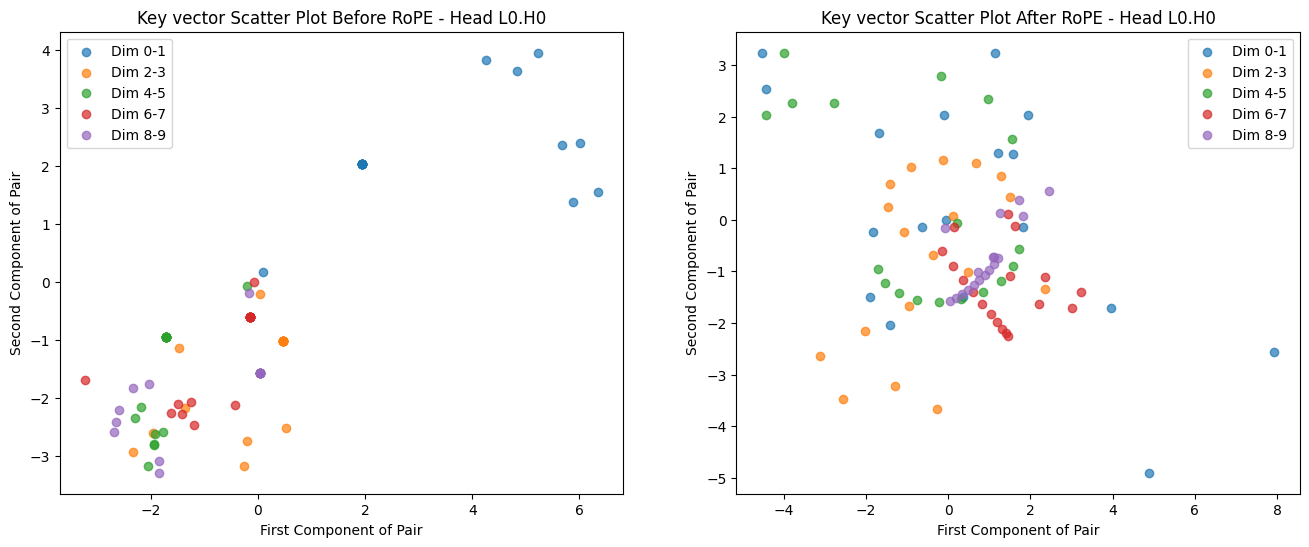

In [ ]:
# Choose a sequence index and attention head to visualize
batch_idx = 0
head_idx = 0

stripped_tokens = strip_eot(all_tokens[seq_idx], model.tokenizer.pad_token_id)
print(f'Prompt: {model.to_string(stripped_tokens)}')

# Extract activations for one head at the chosen sequence index (before and after RoPE)
pre_k_head = pre_rot_k_cached[batch_idx, :, head_idx, :].cpu().numpy()  # Pre-RoPE (Shape: seq_len, head_dim)
post_k_head = rot_act_k_cached[batch_idx, :, head_idx, :].cpu().numpy()  

# Define 2D subspaces for visualization
dim_pairs = list(range(0, q_head_post.shape[1], 2))  # Take pairs (0,1), (2,3), etc.

# --- Side by Side Scatter Plot: Pre-RoPE and Post-RoPE Queries ---
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pre-RoPE Queries
for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
    axes[0].scatter(pre_k_head[:, dim], pre_k_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
axes[0].set_title(f"Key vector Scatter Plot Before RoPE - Head L0.H{head_idx}")
axes[0].set_xlabel("First Component of Pair")
axes[0].set_ylabel("Second Component of Pair")
axes[0].legend()

# Post-RoPE Queries
for dim in dim_pairs[:5]:  # Only plot a few pairs for readability
    axes[1].scatter(post_k_head[:, dim], post_k_head[:, dim + 1], label=f"Dim {dim}-{dim+1}", alpha=0.7)
axes[1].set_title(f"Key vector Scatter Plot After RoPE - Head L0.H{head_idx}")
axes[1].set_xlabel("First Component of Pair")
axes[1].set_ylabel("Second Component of Pair")
axes[1].legend()

plt.show()

--------------------------------------------------------------------------------
TSNE(early_exaggeration=12, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 17 nearest neighbors using exact search using euclidean distance...


   --> Time elapsed: 0.02 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.00 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.00 seconds
===> Running optimization with exaggeration=12.00, lr=1.50 for 250 iterations...
Iteration   50, KL divergence 0.7238, 50 iterations in 0.0056 sec
Iteration  100, KL divergence 0.5973, 50 iterations in 0.0043 sec
Iteration  150, KL divergence 0.5146, 50 iterations in 0.0042 sec
Iteration  200, KL divergence 0.5891, 50 iterations in 0.0044 sec
Iteration  250, KL divergence -0.0578, 50 iterations in 0.0043 sec
   --> Time elapsed: 0.02 seconds
===> Running optimization with exaggeration=1.00, lr=18.00 for 500 iterations...
Iteration   50, KL divergence 0.0693, 50 iterations in 0.0039 sec
Iteration  100, KL divergence 0.0671, 50 iterations in 0.0036 sec
Iteration  150, KL divergence 0.0664, 50 iterations in 0.0036 sec
Iteration  200, KL divergence 0.0653, 50 iterations in 0.0037 sec
Iteration  250, KL diverge

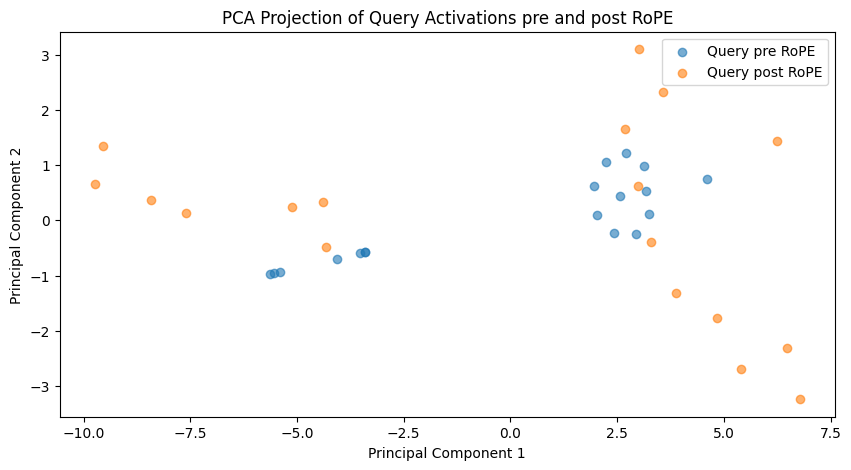

In [ ]:
# openTSNE, faster implementation of TSNE with Davies-Bouldin approximation: https://opentsne.readthedocs.io/en/stable/examples/01_simple_usage/01_simple_usage.html
from openTSNE import TSNE 

pca1 = TSNE(n_components=2, random_state=42, verbose=True)
pca2 = TSNE(n_components=2, random_state=42, verbose=True)
q_pre_pca = pca1.fit(pre_q_head)
q_post_pca = pca2.fit(post_q_head)

plt.figure(figsize=(10, 5))
plt.scatter(q_pre_pca[:, 0], q_pre_pca[:, 1], alpha=0.6, label="Query pre RoPE")
plt.scatter(q_post_pca[:, 0], q_post_pca[:, 1], alpha=0.6, label="Query post RoPE")
plt.title("PCA Projection of Query Activations pre and post RoPE")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend()
plt.show()